# FRESCO Analytics Notebook
### Overview
This notebook has been designed to make analysis of the Anvil dataset as easy as possible. Generally speaking, it will allow the user to access the Anvil files stored locally, select a number of analysis options, and view the results.
### Instructions
1. Run the first cell and provide the window for your dataset. This window of time will be used to pull the host timeseries and job accounting data from the database.
2. Run cell 2 and select the desired preprocessing options (can be more than one).
3. Run cell 3 and select the desired host data time series units to be included (can be more than one).
4. Run cell 4 and provide the desired values and options. **Note**: if units were selected in step 3, the "Save Values" button must be selected before moving on.
5. Run cell 5 and select the desired options.
6. Run cell 6 to see your data visualizations. If you would like to explore correlations among metrics and statistics, select from the provided options.
7. Run cell 7 to see the correlation visualizations.
8. Run cell 8 and download the desired data.


In [22]:
# -------------- CELL 1 --------------
from IPython.display import display, FileLink, clear_output, display
import ipywidgets as widgets
import notebook_functions as nbf
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl


print(r"Please provide a time window for your host dataset.")

start_time = widgets.NaiveDatetimePicker(
    value=datetime.now().replace(microsecond=0),
    placeholder='',
    description='Start Time:',
    disabled=False
)

end_time = widgets.NaiveDatetimePicker(
    value=datetime.now().replace(microsecond=0),
    placeholder='',
    description='End Time:',
    disabled=False
)

def validate_date_range(change):
    # 'change' includes information about the change event
    # including the 'owner' which is the widget itself
    if change['owner'] == start_time:
        if end_time.value and change['new'] >= end_time.value:
            print("Error: Start Time should be less than End Time")
        else:
            print("Time range is valid")
    elif change['owner'] == end_time:
        if start_time.value and change['new'] <= start_time.value:
            print("Error: End Time should be greater than Start Time")
        else:
            print("Time range is valid")

# Attach the validation function to the 'value' trait of the date picker widgets
start_time.observe(validate_date_range, 'value')
end_time.observe(validate_date_range, 'value')

display(start_time, end_time)

Please provide a time window for your host dataset.


NaiveDatetimePicker(value=datetime.datetime(2023, 7, 3, 15, 49, 4), description='Start Time:')

NaiveDatetimePicker(value=datetime.datetime(2023, 7, 3, 15, 49, 4), description='End Time:')

In [23]:
# -------------- CELL 2 --------------

print("Data preprocessing: select either option (or both):")
preprocessing = widgets.SelectMultiple(
    options=['None', 'Remove Rows with Missing Metrics?', 'Add an Interval Column?'],
    value=['None'],
    description='Options:',
    disabled=False,
)

display(preprocessing)

Data preprocessing: select either option (or both):


SelectMultiple(description='Options:', index=(0,), options=('None', 'Remove Rows with Missing Metrics?', 'Add …

In [24]:
# -------------- CELL 3 --------------

# get timeseries from the DB
# time_series_df = nbf.get_time_series_from_database(start_time.value.strftime('%Y-%m-%d %H:%M:%S'), end_time.value.strftime('%Y-%m-%d %H:%M:%S'))

# TODO: REMOVE WHEN DONE WITH DEV
time_series_df = pd.read_csv("job_ts_metrics_july2022_anon.csv")
# TODO: REMOVE WHEN DONE WITH DEV

# get the account logs from the DB
account_log_df = nbf.get_account_log_from_database(start_time.value.strftime('%Y-%m-%d %H:%M:%S'), end_time.value.strftime('%Y-%m-%d %H:%M:%S'))

# do the preprocessing
for value in preprocessing.value:
    if "Remove" in value:
        time_series_df = time_series_df.dropna()
    if "Add" in value:
        time_series_df = nbf.add_interval_column(end_time.value, time_series_df)

print("Optional: select the units to be included in the timeseries data.")
units = widgets.SelectMultiple(
    options=['None', 'CPU %', 'GPU %', 'GB:memused', 'GB:memused_minus_diskcache', 'GB/s', 'MB/s'],
    value=['None'],
    description='Units:',
    disabled=False,
)

display(units)


Optional: select the units to be included in the timeseries data.


SelectMultiple(description='Units:', index=(0,), options=('None', 'CPU %', 'GPU %', 'GB:memused', 'GB:memused_…

In [25]:
# -------------- CELL 4 --------------

unit_values = {}  # stores user low and high value user input such that: key = a unit from the units list above /// value = (low_value, high_value)

for value in units.value:
    if value != 'None':
        nbf.setup_widgets(unit_values, value)

print("Optional: provide the hosts to be included in the timeseries data e.g., 'NODE1, NODE2'")
hosts = widgets.Text(
    value='',
    placeholder='',
    description='Hosts:',
    disabled=False
)
display(hosts)

print("Optional: provide the jobs to be included in the timeseries data e.g., 'JOB1, JOB2'")
job_ids = widgets.Text(
    value='',
    placeholder='',
    description='Jobs:',
    disabled=False
)
display(job_ids)

print("Optional: select if you want the account logs to be returned for the Job IDs matching your query.")
return_account_logs = widgets.ToggleButton(
    value=False,
    description='Account Logs',
    disabled=False,
    button_style='',
    tooltip='Return Account Logs?',
    icon='check'
)
display(return_account_logs)

print("Optional: select the columns to be included in the timeseries data (hold control to select multiple). If no columns are "
      "selected, all columns will be included.")
timeseries_return_columns = widgets.SelectMultiple(
    options=['None', 'Job Id', 'Hosts', 'Events', 'Units', 'Values', 'Timestamps'],
    value=['None'],
    description='Return Columns',
    disabled=False
)
display(timeseries_return_columns)

Optional: provide the hosts to be included in the timeseries data e.g., 'NODE1, NODE2'


Text(value='', description='Hosts:', placeholder='')

Optional: provide the jobs to be included in the timeseries data e.g., 'JOB1, JOB2'


Text(value='', description='Jobs:', placeholder='')

Optional: select if you want the account logs to be returned for the Job IDs matching your query.


ToggleButton(value=False, description='Account Logs', icon='check', tooltip='Return Account Logs?')

Optional: select the columns to be included in the timeseries data (hold control to select multiple). If no columns are selected, all columns will be included.


SelectMultiple(description='Return Columns', index=(0,), options=('None', 'Job Id', 'Hosts', 'Events', 'Units'…

In [26]:
unit_values  # TODO: remove when done with dev work

{}

In [27]:
# -------------- CELL 5 --------------

# if units.value != "None":
#     time_series_df = nbf.get_timeseries_by_values_and_unit(unit_values, time_series_df)
#
# if len(hosts.value) > 0:
#     time_series_df = nbf.get_timeseries_by_hosts(hosts.value, time_series_df)
#
# if len(job_ids.value) > 0:
#     account_log_df = nbf.get_timeseries_by_job_ids(job_ids.value)
#
# if return_account_logs:
#     account_log_df = nbf.get_account_logs_by_job_ids(time_series_df, account_log_df)

# -------------- timeseries download --------------

print("Do you want to download the filtered timeseries data?")
csv_download_button = widgets.Button(description="Download as CSV")
excel_download_button = widgets.Button(description="Download as Excel")

def on_csv_button_clicked(b):
    display(nbf.create_csv_download_link(time_series_df, title="Download timeseries CSV"))

def on_excel_button_clicked(b):
    display(nbf.create_excel_download_link(time_series_df, title="Download timeseries Excel"))

csv_download_button.on_click(on_csv_button_clicked)
excel_download_button.on_click(on_excel_button_clicked)
display(csv_download_button, excel_download_button)

# -------------- account log download --------------

print("Do you want to download the filtered accounting data?")
csv_acc_download_button = widgets.Button(description="Download as CSV")
excel_acc_download_button = widgets.Button(description="Download as Excel")

def on_acc_csv_button_clicked(b):
    display(nbf.create_csv_download_link(account_log_df, title="Download accounting CSV"))

def on_acc_excel_button_clicked(b):
    display(nbf.create_excel_download_link(account_log_df, title="Download accounting Excel"))

csv_acc_download_button.on_click(on_acc_csv_button_clicked)
excel_acc_download_button.on_click(on_acc_excel_button_clicked)
display(csv_acc_download_button, excel_acc_download_button)

# -------------- stats options --------------
stats = widgets.SelectMultiple(
    options=['None', 'Average', 'Mean', 'Median', 'Standard Deviation', 'PDF', 'CDF', 'Ratio of Data Outside Threshold'],
    value=['None'],
    description='Statistics',
    disabled=False
)

interval_type = widgets.Dropdown(
    options=['None', 'Count', 'Time'],
    value='None',
    description='Interval Type',
    disabled=True  # disabled by default
)

time_units = widgets.Dropdown(
    options=['None', 'Days', 'Hours', 'Minutes', 'Seconds'],
    value='None',
    description='Interval Unit',
    disabled=True  # disabled by default
)

time_value = widgets.IntText(
    value=0,
    description='Value:',
    disabled=True  # disabled by default
)

# Define a function to be called when stats value changes
def on_stats_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'][0] != "None":  # enable interval_type if stats is not None
            interval_type.disabled = False
        else:  # disable interval_type if stats is None
            interval_type.disabled = True
            interval_type.value = 'None'  # reset interval_type to 'None'

stats.observe(on_stats_change)

# Define a function to be called when interval_type value changes
def on_interval_type_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == "None":
            time_units.disabled = True
            time_value.disabled = True
            time_units.value = 'None'  # reset time_units to 'None'
            time_value.value = 0  # reset time_value to 0
        elif change['new'] == "Time":
            time_units.disabled = False
            time_value.disabled = False
        elif change['new'] == "Count":
            time_units.disabled = True
            time_value.disabled = False
        else:
            time_units.disabled = False
            time_value.disabled = False

interval_type.observe(on_interval_type_change)

# Display the widgets
print("Please select a statistic to calculate.")
display(stats)
print("Please select an interval type to use in the statistic calculation. If count is selected, the interval will correspond to a count of rows. If time is selected, the interval will be a time window.")
display(interval_type)
print("If time was selected, please select the unit of time.")
display(time_units)
print("Please provide the interval count.")
display(time_value)

Do you want to download the filtered timeseries data?


Button(description='Download as CSV', style=ButtonStyle())

Button(description='Download as Excel', style=ButtonStyle())

Do you want to download the filtered accounting data?


Button(description='Download as CSV', style=ButtonStyle())

Button(description='Download as Excel', style=ButtonStyle())

Please select a statistic to calculate.


SelectMultiple(description='Statistics', index=(0,), options=('None', 'Average', 'Mean', 'Median', 'Standard D…

Please select an interval type to use in the statistic calculation. If count is selected, the interval will correspond to a count of rows. If time is selected, the interval will be a time window.


Dropdown(description='Interval Type', disabled=True, options=('None', 'Count', 'Time'), value='None')

If time was selected, please select the unit of time.


Dropdown(description='Interval Unit', disabled=True, options=('None', 'Days', 'Hours', 'Minutes', 'Seconds'), …

Please provide the interval count.


IntText(value=0, description='Value:', disabled=True)

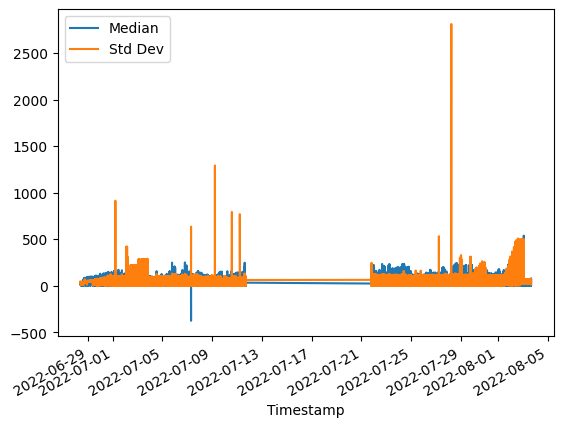

If you would like to explore correlations among metrics and statistics, select from the options below:


SelectMultiple(description='Metrics', index=(0,), options=('None', 'CPU %', 'GPU %', 'GB(memused_minus_diskcac…

SelectMultiple(description='Statistics', index=(1,), options=('Average', 'Mean', 'Median', 'Standard Deviation…

In [28]:
# -------------- CELL 6 --------------
# Convert the 'Timestamp' columns to datetime
time_series_df['Timestamp'] = pd.to_datetime(time_series_df['Timestamp'])
# account_log_df['Timestamp'] = pd.to_datetime(account_log_df['Timestamp'])

# set the 'Timestamp' column as the index
time_series_df = time_series_df.set_index('Timestamp')
# account_log_df = account_log_df.set_index('Timestamp')

# sort each by timestamp
time_series_df = time_series_df.sort_index()
# account_log_df = account_log_df.sort_index()

df_avg, df_mean, df_median, df_std = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
time_map = {'Days': 'D', 'Hours': 'H', 'Minutes': 'T', 'Seconds': 'S'}

pdf, cdf, ratio = False, False, False

# Calculate stats:
for choice in stats.value:
    if choice == "Average":
        if interval_type.value == "Time":
            df_avg = nbf.get_average(time_series_df, True, f"{time_value.value}{time_map[time_units.value]}")
        elif interval_type.value == "Count":
            df_avg = nbf.get_average(time_series_df, True, time_value.value)
        else:
            df_avg = nbf.get_average(time_series_df)
    if choice == "Mean":
        if interval_type.value == "Time":
            df_mean = nbf.get_mean(time_series_df, True, f"{time_value.value}{time_map[time_units.value]}")
        elif interval_type.value == "Count":
            df_mean = nbf.get_mean(time_series_df, True, time_value.value)
        else:
            df_mean = nbf.get_mean(time_series_df)
    if choice == "Median":
        if interval_type.value == "Time":
            df_median = nbf.get_median(time_series_df, True, f"{time_value.value}{time_map[time_units.value]}")
        elif interval_type.value == "Count":
            df_median = nbf.get_median(time_series_df, True, time_value.value)
        else:
            df_median = nbf.get_median(time_series_df)
    if choice == "Standard Deviation":
        if interval_type.value == "Time":
            df_std = nbf.get_standard_deviation(time_series_df, True, f"{time_value.value}{time_map[time_units.value]}")
        elif interval_type.value == "Count":
            df_std = nbf.get_standard_deviation(time_series_df, True, time_value.value)
        else:
            df_std = nbf.get_standard_deviation(time_series_df)
    if choice == "PDF":
        pdf = True
    if choice == "CDF":
        cdf = True
    if choice == "Ratio of Data Outside Threshold":
        ratio = True

# Display statistical data of the average, mean, median, and std dev dataframes (for each that have data)
for choice in stats.value:
    if choice == "Average":
        df_avg['Value'].plot(label='Average')
    if choice == "Mean":
        df_mean['Value'].plot(label='Mean')
    if choice == "Median":
        df_median['Value'].plot(label='Median')
    if choice == "Standard Deviation":
        df_std['Value'].plot(label='Std Dev')

plt.legend(loc='upper left')
plt.show()

# plt.plot(df_median['Value'].to_list(), df_median['Timestamp'].to_list())


# Give the user the option to calculate correlations
print("If you would like to explore correlations among metrics and statistics, select from the options below:")

correlations = widgets.SelectMultiple(
    options=['None', 'CPU %', 'GPU %', 'GB(memused_minus_diskcache)', 'GB(memused)', 'GB/s', 'MB/s'],
    value=['None'],
    description='Metrics',
    disabled=False
)

stats = widgets.SelectMultiple(
    options=['Average', 'Mean', 'Median', 'Standard Deviation', 'PDF', 'CDF', 'Ratio of Data Outside Threshold'],
    value=['Mean'],
    description='Statistics',
    disabled=False
)

display(correlations, stats)


In [ ]:
# -------------- CELL 7 --------------

# calculate correlations
nbf.calculate_correlation()

# Display correlation visualizations here


In [ ]:
# -------------- CELL 8 ---------------

# Give the user the option to download data here.
print("Select the files to be downloaded:")
files_to_provide = widgets.SelectMultiple(
    options=['None', 'job_ts_metrics_aug2022_anon', 'job_ts_metrics_dec2022_anon',
             'job_ts_metrics_jan2022_anon', 'job_ts_metrics_july2022_anon',
             'job_ts_metrics_nov2022_anon', 'job_ts_metrics_sep2022_anon'],
    value=['None'],
    description='Files',
    disabled=False
)
display(files_to_provide)

# Create and display download button
download_button = widgets.Button(description='Download File/s')
download_button.on_click(nbf.on_download_button_clicked)
display(download_button)

In [ ]:
# -------------- CELL 9 ---------------
